In [13]:
import sys
sys.path.insert(0, "../src")

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

import sys
if '..' not in sys.path:
    sys.path.append('..')

from probabilistic_model import ProbabilisticModel

np.random.seed(1)

In [15]:
MODEL = 'mbpol'
state_labels = {
    'hda': 0,
    'lda': 1,
    'liquid': 2,
    'ice': 3
}
probabilities = {
    16: {'hda': [], 'lda': []},
    12: {'hda': [], 'lda': []},
    8: {'hda': [], 'lda': []},
    7: {'hda': [], 'lda': []},
    6: {'hda': [], 'lda': []},
    5: {'hda': [], 'lda': []},
    4: {'hda': [], 'lda': []},
    3: {'hda': [], 'lda': []},
    2: {'hda': [], 'lda': []}
}
ice_probabilities = {
    16: {'hda': [], 'lda': []},
    12: {'hda': [], 'lda': []},
    8: {'hda': [], 'lda': []},
    7: {'hda': [], 'lda': []},
    6: {'hda': [], 'lda': []},
    5: {'hda': [], 'lda': []},
    4: {'hda': [], 'lda': []},
    3: {'hda': [], 'lda': []},
    2: {'hda': [], 'lda': []}
}
accuracies = {
    'mbpol': {},
    'scan': {}
}

In [16]:
def load_data(model, size, states=['hda', 'lda']):
    ''' Method for efficiently loading environments for a given number of neighbors. '''
    desc_dir = '..'
    descs = []
    labels = []
    for state in states:
        acsf = np.load(f'{desc_dir}/data/descriptors/neigh_{size}/{model}_{state}_acsf.npy')
        stein = np.load(f'{desc_dir}/data/descriptors/neigh_{size}/{model}_{state}_stein.npy')[:,0:10]
        desc = np.hstack((acsf, stein))
        descs.append(desc)
        for _ in range(desc.shape[0]):
            labels.append(state_labels[state])
    desc = np.vstack(descs)
    labels = np.array(labels)
    return desc, labels

In [4]:
for MODEL in ['scan', 'mbpol']:
    for NUM in [16, 12, 8, 5, 4, 3, 2]:
        print(f'Working on {MODEL} and size {NUM}.')

        # Prepare training set for our model.
        X, y = load_data(model=MODEL, size=NUM, states=['hda', 'lda'])
        hda_idx = np.argwhere(y == 0).reshape(-1)
        lda_idx = np.argwhere(y == 1).reshape(-1)

        # Assess classification accuracy for our model.
        metrics = {
            'hda_precisions': [],
            'lda_precisions': [],
            'hda_recalls': [],
            'lda_recalls': [],
            'accuracies': []
        }
        kf = KFold(n_splits=5, shuffle=True, random_state=1)
        for idx, (train_idx, test_idx) in enumerate(kf.split(X)):
            print(f'Evaluating fold {idx + 1} / 5.')
            X_train = X[train_idx]
            y_train = y[train_idx]
            X_test = X[test_idx]
            y_test = y[test_idx]
            X_train = np.vstack((X_train))
            y_train = np.hstack((y_train))
            model = ProbabilisticModel(max_features=5, detect_outliers=False, corr_cut=0.8)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test, binary=True)   # Only consider HDA/LDA predictions.
            probs = model.confidence(X_test, binary=True) # Only consider HDA/LDA predictions.

            # Save probabilities for true configurations for subsequent analysis.
            lda_idx = np.argwhere(y_test == 1).reshape(-1) 
            hda_idx = np.argwhere(y_test == 0).reshape(-1) 
            lda_probs = probs[lda_idx, 1]
            hda_probs = probs[hda_idx, 0]
            probabilities[NUM]['lda'].append(lda_probs)
            probabilities[NUM]['hda'].append(hda_probs)
            
            # Save performance metrics.
            valid_idx = np.argwhere(y_pred != -1).reshape(-1)
            conf_mat = confusion_matrix(y_test[valid_idx], y_pred[valid_idx])
            metrics['hda_precisions'].append(conf_mat[0,0] / (conf_mat[1,0] + conf_mat[0,0]))
            metrics['lda_precisions'].append(conf_mat[1,1] / (conf_mat[0,1] + conf_mat[1,1]))
            metrics['hda_recalls'].append(conf_mat[0,0] / (conf_mat[0,1] + conf_mat[0,0]))
            metrics['lda_recalls'].append(conf_mat[1,1] / (conf_mat[1,0] + conf_mat[1,1]))
            metrics['accuracies'].append((conf_mat[0,0] + conf_mat[1,1]) / np.sum(conf_mat, axis=(0,1)))

        # Save accuracies.
        accuracies[MODEL][NUM] = (np.mean(metrics['accuracies']), np.std(metrics['accuracies']))

        # # Get predictions on ice configurations.
        # print('Evaluating model on ice configurations...')
        # X = np.vstack((X, X_liquid))
        # y = np.hstack((y, y_liquid))
        # model = ProbabilisticModel(max_features=10, include=0.98, detect_outliers=False)
        # model.fit(X_train, y_train)
        # X_ice_acsf = np.load(f'../descriptors/neigh_{NUM}/{MODEL}_ice_acsf.npy')
        # X_ice_stein = np.load(f'../descriptors/neigh_{NUM}/{MODEL}_ice_stein.npy')
        # X_ice = np.hstack((X_ice_acsf, X_ice_stein))
        # prob_ice = model.confidence(X_ice, binary=True)
        # ice_probabilities[NUM]['hda'] = prob_ice[:,0]
        # ice_probabilities[NUM]['lda'] = prob_ice[:,1]
        # print('Completed.')

Working on scan and size 16.
Evaluating fold 1 / 5.
Evaluating fold 2 / 5.
Evaluating fold 3 / 5.
Evaluating fold 4 / 5.
Evaluating fold 5 / 5.
Working on scan and size 12.
Evaluating fold 1 / 5.
Evaluating fold 2 / 5.
Evaluating fold 3 / 5.
Evaluating fold 4 / 5.
Evaluating fold 5 / 5.
Working on scan and size 8.
Evaluating fold 1 / 5.
Evaluating fold 2 / 5.
Evaluating fold 3 / 5.
Evaluating fold 4 / 5.
Evaluating fold 5 / 5.
Working on scan and size 5.
Evaluating fold 1 / 5.
Evaluating fold 2 / 5.
Evaluating fold 3 / 5.
Evaluating fold 4 / 5.
Evaluating fold 5 / 5.
Working on scan and size 4.
Evaluating fold 1 / 5.
Evaluating fold 2 / 5.
Evaluating fold 3 / 5.
Evaluating fold 4 / 5.
Evaluating fold 5 / 5.
Working on scan and size 3.
Evaluating fold 1 / 5.
Evaluating fold 2 / 5.
Evaluating fold 3 / 5.
Evaluating fold 4 / 5.
Evaluating fold 5 / 5.
Working on scan and size 2.
Evaluating fold 1 / 5.
Evaluating fold 2 / 5.
Evaluating fold 3 / 5.
Evaluating fold 4 / 5.
Evaluating fold 5 / 

In [5]:
import pickle
pickle.dump(accuracies, open('./data/size_accuracies.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
import pickle
accuracies = pickle.load(open('./data/size_accuracies.pkl', 'rb'))

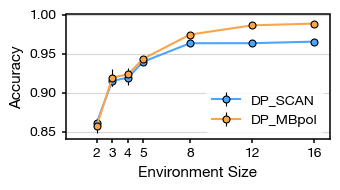

In [18]:
# Make a plot of the accuracies vs. the number of water molecules in the atomic environment.
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'Helvetica Neue'
plt.rcParams['axes.linewidth'] = 1.1
fig, ax = plt.subplots(1,1,figsize=(3.5,2.0))
scan_color = '#4DA5FE'
mbpol_color = '#F9A54B'
ax.errorbar(
    accuracies['scan'].keys(), 
    [accuracies['scan'][k][0] for k in accuracies['scan'].keys()], 
    yerr=[accuracies['scan'][k][1] for k in accuracies['scan'].keys()], 
    color=scan_color, marker='o', markersize=5.0, markeredgecolor='black', markeredgewidth=0.8,
    ecolor='black', elinewidth=0.8, label='DP_SCAN', clip_on=False
)
ax.errorbar(
    accuracies['mbpol'].keys(), 
    [accuracies['mbpol'][k][0] for k in accuracies['mbpol'].keys()], 
    yerr=[accuracies['mbpol'][k][1] for k in accuracies['mbpol'].keys()], 
    color=mbpol_color, marker='o', markersize=5.0, markeredgecolor='black', markeredgewidth=0.8,
    ecolor='black', elinewidth=0.8, label='DP_MBpol', clip_on=False
)
ax.set_xlabel('Environment Size', size=11)
ax.set_ylabel('Accuracy', size=11)
ax.set_ylim(ymin=0.84, ymax=1.0)
ax.set_yticks(ticks=[0.85, 0.90, 0.95, 1.0])
ax.set_xlim(xmin=0, xmax=17)
ax.set_xticks(ticks=[2, 3, 4, 5, 8, 12, 16])
# ax.yaxis.minorticks_on()
ax.tick_params(axis='both', width=1.1, length=3.0)
# ax.spines[['top', 'right']].set_visible(False)
ax.grid(alpha=0.5, axis='y')
plt.legend(edgecolor='white', loc='lower right')
plt.tight_layout()
plt.savefig('./figures/size_accuracy.svg', dpi=1000)
plt.show()

In [19]:
# Analyze features used by models with environment sizes of 3 water molecules.
def get_feature_names():
    '''Method for generating feature names for ACSFs and Steinhardt parameters.'''
    from dscribe.descriptors import ACSF
    from steinhardt import desc_to_index_mapping
    feature_names = []
    acsf = ACSF(
        species=['H', 'O'],
        periodic=False,
        r_cut=5.0,
        g2_params=[[0.5, 1.0],[1.0, 1.0],[1.5, 1.0],[2.0, 1.0],[2.5, 1.0],[3.0, 1.0],[3.5, 1.0],[4.0, 1.0],[4.5, 1.0],[5.0, 1.0]],
        g3_params=[0.5, 1.0, 1.5, 2.0],
        g4_params=[[0.0, 1.0, 1.0],[0.0, 0.5, 1.0],[2.0, 1.0, 1.0],[2.0, 0.5, 1.0],[4.5, 1.0, 1.0],[4.5, 0.5, 1.0],[0.0, 1.0, -1.0],[0.0, 0.5, -1.0],[2.0, 1.0, -1.0],[2.0, 0.5, -1.0],[4.5, 1.0, -1.0],[4.5, 0.5, -1.0]],
        g5_params=[[2.0, 1.0, 1.0],[2.0, 0.5, 1.0],[4.5, 1.0, 1.0],[4.5, 0.5, 1.0],[2.0, 1.0, -1.0],[2.0, 0.5, -1.0],[4.5, 1.0, -1.0],[4.5, 0.5, -1.0]]
    )
    for spec in ['H', 'O']:
        feature_names.append(f'G1 | {spec}')
        for param_set in acsf.g2_params:
                feature_names.append(f'G2 | {spec} | {param_set}')
        for param_set in acsf.g3_params:
            feature_names.append(f'G3 | {spec} | {param_set}')
    for spec in ['H-H', 'H-O', 'O-O']:
        for param_set in acsf.g4_params:
            feature_names.append(f'G4 | {spec} | {param_set}')
        for param_set in acsf.g5_params:
            feature_names.append(f'G5 | {spec} | {param_set}')
    for key in desc_to_index_mapping.keys():
        feature_names.append(key)
    return feature_names

In [ ]:
X, y = load_data(model='mbpol', size=3, states=['hda', 'lda'])
hda_idx = np.argwhere(y == 0).reshape(-1)
lda_idx = np.argwhere(y == 1).reshape(-1)
model = ProbabilisticModel(
    max_features=5, 
    include=0.98,
    detect_outliers=False,
    corr_cut=0.8,
    use_features=[13, 12, 1, 70, 57, 0]
)
model.fit(X, y)
print(f'Chosen features: {model.chosen_features}')
feature_names = get_feature_names()
for i, idx in enumerate(model.chosen_features):
    print(feature_names[idx], model.mutual_information[i])

Chosen features: [13, 12, 1, 70, 57, 0]
G3 | H | 1.5 0.4619446270438008
G3 | H | 1.0 0.27104059864984614
G2 | H | [0.5, 1.0] 0.18087760597961858
G4 | O-O | [0.0, 1.0, 1.0] 0.1522545277026948
G4 | H-O | [0.0, 0.5, -1.0] 0.12707926105393344
G1 | H 0.3636293695976194


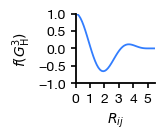

In [64]:
# Visualize the first considered function.
plt.rcParams['font.family'] = 'Helvetica Neue'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 1.3
fig, ax = plt.subplots(1,1,figsize=(1.75,1.5))

# Compute the first ACSF.
x = np.linspace(0.0, 5.5)
y = np.cos(1.5 * x) * 0.5 * (np.cos((np.pi * x) / 5) + 1)
x_cut = np.argwhere(x > 5.0).reshape(-1)
y[x_cut] = 0.0

# Plot.
ax.plot(x, y, color="#327DFE", linewidth=1.3)
ax.set_xlim(xmin=0.0, xmax=5.5)
ax.set_ylim(ymin=-1.0, ymax=1.0)
ax.set_xlabel(r'$R_{ij}$')
ax.set_ylabel(r'$f(G_\text{H}^{3})$')
ax.set_xticks(ticks=[0, 1, 2, 3, 4, 5])
ax.set_yticks(ticks=[-1.0, -0.5, 0.0, 0.5, 1.0])
ax.tick_params(axis='both', width=1.2, length=3.6)
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.savefig('./figures/size_acsf.svg', dpi=1000, transparent=True)
plt.show()

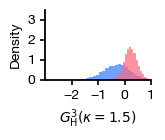

In [44]:
# Visualize distributions of environments along G3H for 16 neighbors. 
X, y = load_data(model='mbpol', size=16, states=['hda', 'lda'])
hda_idx = np.argwhere(y == 0).reshape(-1)
lda_idx = np.argwhere(y == 1).reshape(-1)
feat_hda = X[hda_idx, 13]
feat_lda = X[lda_idx, 13]

plt.rcParams['font.family'] = 'Helvetica Neue'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 1.3
fig, ax = plt.subplots(1,1,figsize=(1.75,1.5))
ax.hist(feat_hda, bins=30, density=True, color='#327DFE', alpha=0.7)
ax.hist(feat_lda, bins=30, density=True, color='#FF667B', alpha=0.7)
ax.set_xlabel(r'$G^{3}_{\text{H}}(\kappa=1.5)$')
ax.set_ylabel('Density')
ax.set_xlim(xmin=-3.0, xmax=1.0)
ax.set_ylim(ymin=0.0, ymax=3.5)
ax.set_xticks(ticks=[-2.0, -1.0, 0, 1])
ax.set_yticks(ticks=[0, 1, 2, 3])
ax.tick_params(axis='both', width=1.2, length=3.6)
ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.savefig('./figures/size_feat_16.svg', dpi=1000, transparent=True)
plt.show()

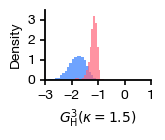

In [45]:
# Visualize distributions of environments along G3H for 3 neighbors. 
X, y = load_data(model='mbpol', size=3, states=['hda', 'lda'])
hda_idx = np.argwhere(y == 0).reshape(-1)
lda_idx = np.argwhere(y == 1).reshape(-1)
feat_hda = X[hda_idx, 13]
feat_lda = X[lda_idx, 13]

plt.rcParams['font.family'] = 'Helvetica Neue'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 1.3
fig, ax = plt.subplots(1,1,figsize=(1.75,1.5))
ax.hist(feat_hda, bins=30, density=True, color='#327DFE', alpha=0.7)
ax.hist(feat_lda, bins=30, density=True, color='#FF667B', alpha=0.7)
ax.set_xlabel(r'$G^{3}_{\text{H}}(\kappa=1.5)$')
ax.set_ylabel('Density')
ax.set_xlim(xmin=-3, xmax=1.0)
ax.set_ylim(ymin=0.0, ymax=3.5)
ax.set_xticks(ticks=[-3, -2.0, -1.0, 0, 1])
ax.set_yticks(ticks=[0, 1, 2, 3])
ax.tick_params(axis='both', width=1.2, length=3.6)
ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.savefig('./figures/size_feat_3.svg', dpi=1000, transparent=True)
plt.show()

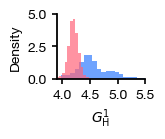

In [54]:
# Visualize distributions of environments along G1H for 3 neighbors. 
X, y = load_data(model='mbpol', size=3, states=['hda', 'lda'])
hda_idx = np.argwhere(y == 0).reshape(-1)
lda_idx = np.argwhere(y == 1).reshape(-1)
feat_hda = X[hda_idx, 0]
feat_lda = X[lda_idx, 0]

plt.rcParams['font.family'] = 'Helvetica Neue'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 1.3
fig, ax = plt.subplots(1,1,figsize=(1.75,1.5))
ax.hist(feat_hda, bins=30, density=True, color='#327DFE', alpha=0.7)
ax.hist(feat_lda, bins=30, density=True, color='#FF667B', alpha=0.7)
ax.set_xlabel(r'$G_\text{H}^{1}$')
ax.set_ylabel('Density')
ax.set_xlim(xmin=3.9, xmax=5.5)
ax.set_ylim(ymin=0.0, ymax=5.0)
ax.set_xticks(ticks=[4, 4.5, 5, 5.5])
ax.set_yticks(ticks=[0.0, 2.5, 5.0])
ax.tick_params(axis='both', width=1.2, length=3.6)
ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.savefig('./figures/size_base_3.svg', dpi=1000, transparent=True)
plt.show()

In [19]:
X, y = load_data(model='scan', size=3, states=['hda', 'lda'])
hda_idx = np.argwhere(y == 0).reshape(-1)
lda_idx = np.argwhere(y == 1).reshape(-1)
model = ProbabilisticModel(
    max_features=5, 
    include=0.98,
    detect_outliers=False,
    corr_cut=0.8,
    # use_features=[13, 12, 1, 70, 57]
)
model.fit(X, y)
print(f'Chosen features: {model.chosen_features}')
feature_names = get_feature_names()
for i, idx in enumerate(model.chosen_features):
    print(feature_names[idx], model.mutual_information[i])

Chosen features: [13, 12, 11, 70, 92]
G3 | H | 1.5 0.4207522727877131
G3 | H | 1.0 0.2702172754171836
G3 | H | 0.5 0.19126559050176356
G4 | O-O | [0.0, 1.0, 1.0] 0.1502833639318898
q5 0.13853802107884597


In [17]:
# Evaluate accuracy of a given model.
X, y = load_data(model='scan', size=3, states=['hda', 'lda'])
hda_idx = np.argwhere(y == 0).reshape(-1)
lda_idx = np.argwhere(y == 1).reshape(-1)

# Assess classification accuracy for our model.
metrics = {
    'hda_precisions': [],
    'lda_precisions': [],
    'hda_recalls': [],
    'lda_recalls': [],
    'accuracies': []
}
kf = KFold(n_splits=5, shuffle=True, random_state=1)
for idx, (train_idx, test_idx) in enumerate(kf.split(X)):
    print(f'Evaluating fold {idx + 1} / 5.')
    X_train = X[train_idx]
    y_train = y[train_idx]
    X_test = X[test_idx]
    y_test = y[test_idx]
    model = ProbabilisticModel(
        max_features=5, detect_outliers=False, corr_cut=0.8,
        use_features=[13, 12, 1, 70, 57]
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test, binary=True)   # Only consider HDA/LDA predictions.
    probs = model.confidence(X_test, binary=True) # Only consider HDA/LDA predictions.
    
    # Save performance metrics.
    valid_idx = np.argwhere(y_pred != -1).reshape(-1)
    conf_mat = confusion_matrix(y_test[valid_idx], y_pred[valid_idx])
    metrics['hda_precisions'].append(conf_mat[0,0] / (conf_mat[1,0] + conf_mat[0,0]))
    metrics['lda_precisions'].append(conf_mat[1,1] / (conf_mat[0,1] + conf_mat[1,1]))
    metrics['hda_recalls'].append(conf_mat[0,0] / (conf_mat[0,1] + conf_mat[0,0]))
    metrics['lda_recalls'].append(conf_mat[1,1] / (conf_mat[1,0] + conf_mat[1,1]))
    metrics['accuracies'].append((conf_mat[0,0] + conf_mat[1,1]) / np.sum(conf_mat, axis=(0,1)))

# Save accuracies.
print(f'Accuracy = {np.mean(metrics["accuracies"])} +/- {np.std(metrics["accuracies"])}')

Evaluating fold 1 / 5.
Evaluating fold 2 / 5.
Evaluating fold 3 / 5.
Evaluating fold 4 / 5.
Evaluating fold 5 / 5.
Accuracy = 0.8981 +/- 0.019164159256278398
